
Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15758/2247027077.py:4: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15758/2247027077.py:4: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15758/2247027077.py:4: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

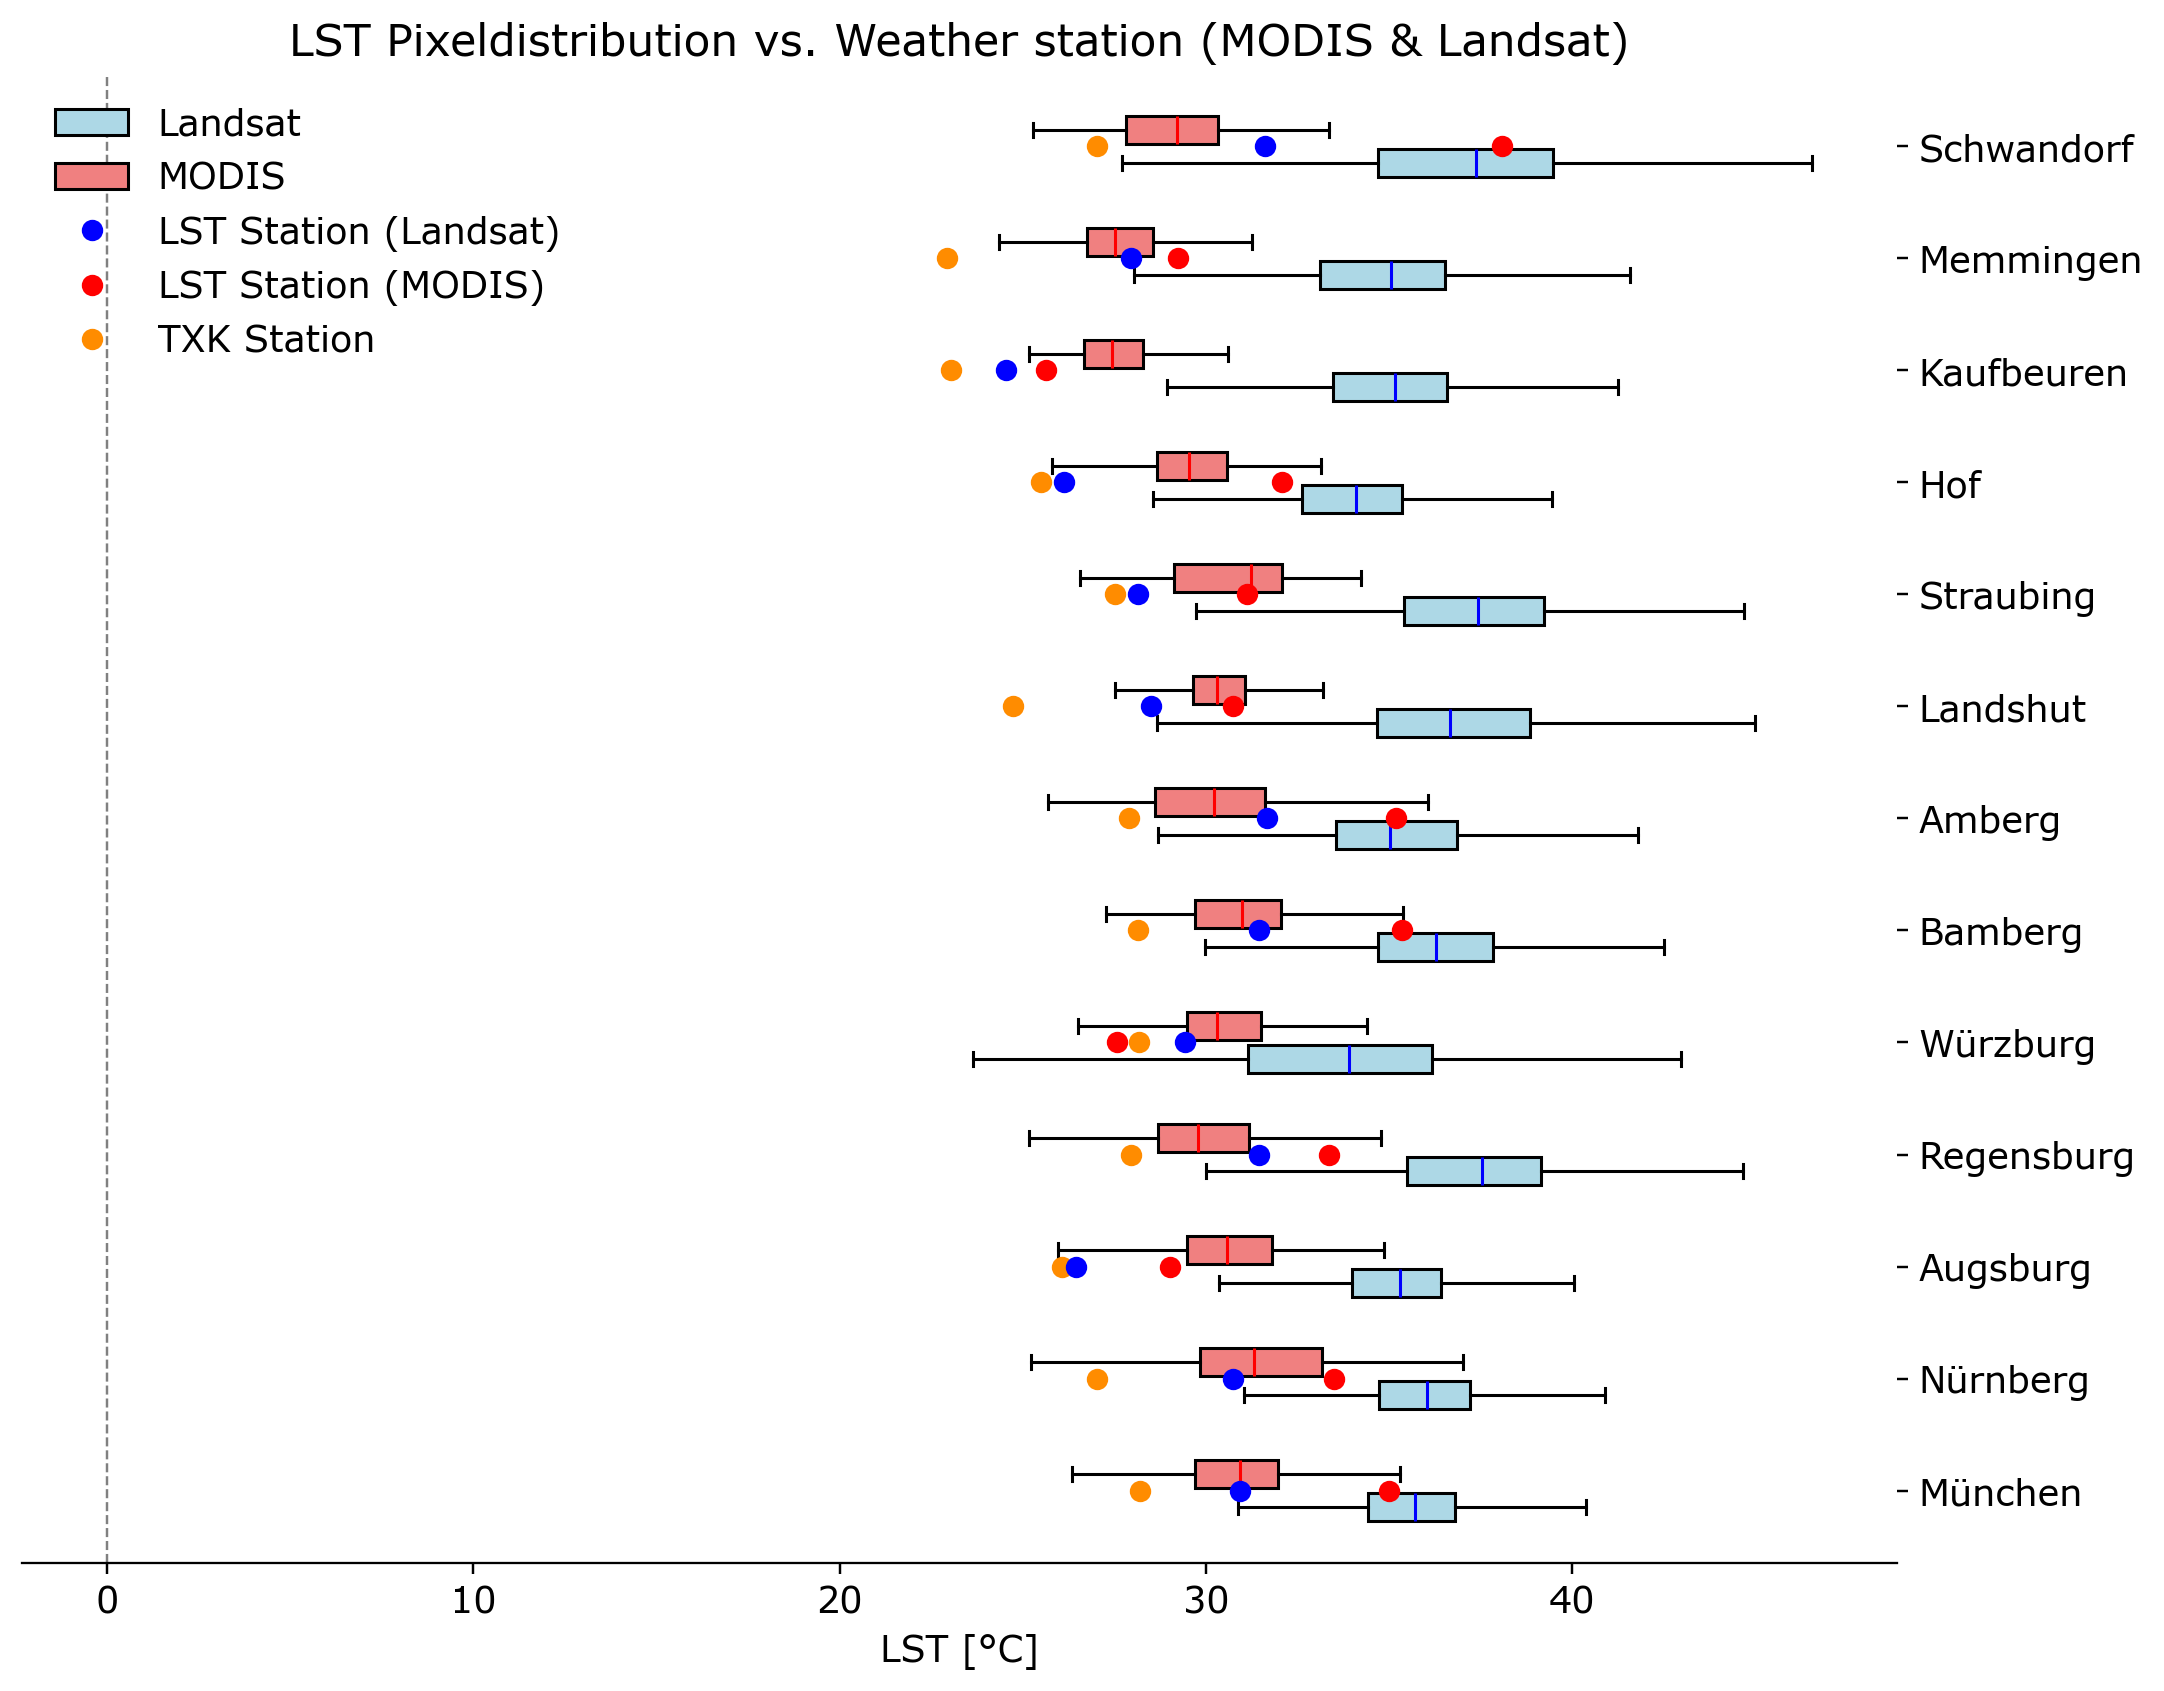

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("FST.mplstyle")

# === 1. Daten einlesen ===
stations_df = pd.read_csv("Input/city_metrics.csv")
landsat_df = pd.read_csv("Input/LST_NDVI_Landcover_Landsat_Bayern.csv")
modis_df = pd.read_csv("Input/LST_all_NDVI_Landcover_Modis_Bayern.csv")
city_size_df = pd.read_excel("Input/Biggest_Cities_Bavaria.xlsx")

# === 2. Spalten vereinheitlichen ===
city_size_df = city_size_df.rename(columns={
    "Name": "City",         # ggf. anpassen
    "Einwohner": "Population"  # ggf. anpassen
})
modis_df = modis_df.rename(columns={"LST_day_Max": "LST_max"})
modis_df["sensor"] = "MODIS"
modis_df["LST_max"] = pd.to_numeric(modis_df["LST_max"], errors="coerce")

landsat_df = landsat_df.rename(columns={"LST_Max": "LST_max"})
landsat_df["sensor"] = "Landsat"

pixels_df = pd.concat([landsat_df, modis_df], ignore_index=True)

# === 3. Wetterstationsdaten (Sommer, MODIS & Landsat) ===
stations_df = stations_df[stations_df["season"] == "Summer"]

# === 4. Städte sammeln ===
unique_cities = pixels_df["City"].dropna().unique()

records = []

for city in unique_cities:
    pix = pixels_df[pixels_df["City"].str.contains(city, case=False, na=False)]
    stn_landsat = stations_df[
        (stations_df["Name"].str.contains(city, case=False, na=False)) &
        (stations_df["sensor"] == "Landsat")
    ]
    stn_modis = stations_df[
        (stations_df["Name"].str.contains(city, case=False, na=False)) &
        (stations_df["sensor"] == "MODIS")
    ]

    if pix.empty or (stn_landsat.empty and stn_modis.empty):
        continue

    ls_vals = pix[pix["sensor"] == "Landsat"]["LST_max"].dropna()
    md_vals = pix[pix["sensor"] == "MODIS"]["LST_max"].dropna()

    if len(ls_vals) + len(md_vals) == 0:
        continue

    lst_stat_landsat = stn_landsat["LST"].mean() if not stn_landsat.empty else np.nan
    lst_stat_modis   = stn_modis["LST"].mean() if not stn_modis.empty else np.nan
    txk_stat         = stn_landsat["TXK"].mean() if not stn_landsat.empty else np.nan

    # Einwohnerzahl suchen
    matching_city = city_size_df[city_size_df["City"].str.contains(city, case=False, na=False)]
    population = matching_city["Population"].values[0] if not matching_city.empty else np.nan

    records.append({
        "City": city,
        "Landsat": ls_vals,
        "MODIS": md_vals,
        "LST_station_landsat": lst_stat_landsat,
        "LST_station_modis": lst_stat_modis,
        "TXK_station": txk_stat,
        "Population": population
    })

# === 5. Sortieren nach Bevölkerung ===
records = sorted(records, key=lambda x: (np.isnan(x["Population"]), -x["Population"] if not np.isnan(x["Population"]) else 0))

# === 6. Plot-Daten vorbereiten ===
order = [r["City"] for r in records]
data_ls_all = [r["Landsat"] for r in records]
data_md_all = [r["MODIS"] for r in records]
lst_landsat_pts = [r["LST_station_landsat"] for r in records]
lst_modis_pts = [r["LST_station_modis"] for r in records]
txk_pts = [r["TXK_station"] for r in records]

# === 7. Plot erstellen ===
y = np.arange(len(order))
offset = 0.15
fig, ax = plt.subplots(figsize=(10, len(order)*0.45 + 2))

# Boxplots
bp_ls = ax.boxplot(
    data_ls_all, positions=y - offset, vert=False, widths=0.25,
    patch_artist=True, showfliers=False,
    boxprops=dict(facecolor="lightblue"), medianprops=dict(color="blue")
)
bp_md = ax.boxplot(
    data_md_all, positions=y + offset, vert=False, widths=0.25,
    patch_artist=True, showfliers=False,
    boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="red")
)

# Wetterstationspunkte
ax.scatter(lst_landsat_pts, y, color="red", label="LST Station (Landsat)", zorder=10)
ax.scatter(lst_modis_pts, y, color="darkorange", label="LST Station (MODIS)", zorder=11)
ax.scatter(txk_pts, y, color="blue", label="TXK Station", zorder=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines["left"].set_visible(False)

# Achsen & Layout
ax.set_yticks(y)
ax.set_yticklabels(order)
ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.set_xlabel("LST [°C]")
ax.set_title("LST Pixeldistribution vs. Weather station (MODIS & Landsat)")

# Legende
ax.legend(
    [bp_ls["boxes"][0], bp_md["boxes"][0],
     plt.Line2D([], [], color="blue", marker="o", linestyle="None"),
     plt.Line2D([], [], color="red", marker="o", linestyle="None"),
     plt.Line2D([], [], color="darkorange", marker="o", linestyle="None")],
    ["Landsat", "MODIS", "LST Station (Landsat)", "LST Station (MODIS)", "TXK Station"],
    loc="upper left"
)

plt.tight_layout()
plt.show()
